# Analysis

## Imports and setup

In [1]:
import argparse
import pickle
from plotnine import *
import json
import pandas as pd
import os
import matplotlib.font_manager as fm
from matplotlib import rcParams
import itertools
import numpy as np
from scipy.stats import bootstrap, ttest_rel
from collections import defaultdict, Counter
import glob

from evaluate import data_generator
from axbench import LatentStatsEvaluator
from tqdm import tqdm
import random

# set the theme
rcParams['font.family'] = "P052"
theme_set(theme_gray(base_family="P052") + theme(axis_text_x=element_text(angle=45, hjust=0.5)))

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [2]:
RESULTS_FOLDERS = [
    "/nlp/scr/aryaman/pyreax/axbench/paper_results",
    "/nlp/scr/wuzhengx/pyreax/axbench/results",
]
SUBFOLDERS = [
    "prod_2b_l10_concept500",
    "prod_2b_l20_concept500",
    "prod_9b_l20_concept500",
    "prod_9b_l31_concept500",
    # "prod_2b_l20_concept16k",
    # "prod_9b_l20_concept16k",
]
PLOT_FOLDER = "paper/"

METHODS = [
    "ig", "lsreft", "steering_vec", "sft", "probe", "no_grad", "crossfit", "lora", "loreft",
    "prompt_detection", "sae_selection", "bow"
]
METHOD_MAP = {
    "LsReFT": "ReFT-r1",
    "SteeringVector": "SSV",
    "SparseLinearProbe": "Probe-SL",
    "DiffMean": "DiffMean",
    "PCA": "PCA",
    "LAT": "LAT",
    "GemmaScopeSAE": "SAE",
    "IntegratedGradients": "IG",
    "InputXGradients": "IxG",
    "LinearProbe": "Probe",
    "PromptSteering": "Prompt",
    "PromptDetection": "Prompt",
    "LoReFT": "LoReFT",
    "LoRA": "LoRA",
    "SFT": "SFT",
    "GemmaScopeSAEMaxAUC": "SAE-A",
    "BoW": "BoW",
}
MODEL_MAP = {
    "2b": "Gemma-2-2B",
    "9b": "Gemma-2-9B",
}
LAYER_MAP = {
    "l10": "L10",
    "l20": "L20",
    "l31": "L31",
}
METRIC_MAP = {
    "macro_avg_accuracy": "Acc. (macro-avg)",
    "max_act": "Max Act.",
    "optimal_threshold": "Optimal Thresh.",
    "roc_auc": "AUROC",
    "max_lm_judge_rating": "Overall Score",
    "max_fluency_rating": "Fluency Score",
    "max_relevance_concept_rating": "Concept Score",
    "max_relevance_instruction_rating": "Instruct Score",
    "max_factor": "Steering Factor",
    "overall_accuracy": "Overall Accuracy",
    "f1": "F1",
    "precision": "Precision",
    "recall": "Recall",
}
FLOAT_METRICS = ['macro_avg_accuracy', 'max_act', 'optimal_threshold', 'roc_auc',
                 'max_lm_judge_rating', 'max_fluency_rating', 'max_relevance_concept_rating',
                 'max_relevance_instruction_rating', 'max_factor', 'overall_accuracy',
                 'f1', 'precision', 'recall', 'max_act_val', 'min_act_val']
INT_METRICS = ['concept_id']

def prettify_df(df):
    # rename columns
    for metric in FLOAT_METRICS:
        if metric in df.columns:
            df[metric] = df[metric].astype(float)
    for metric in INT_METRICS:
        if metric in df.columns:
            df[metric] = df[metric].astype(int)
    if "method" in df.columns:
        df["method"] = df["method"].apply(lambda x: METHOD_MAP.get(x, x))
        df = df.rename(columns={"method": "Method"})
    if "model" in df.columns:
        df["model"] = df["model"].apply(lambda x: MODEL_MAP.get(x, x))
    if "layer" in df.columns:
        df["layer"] = df["layer"].apply(lambda x: LAYER_MAP.get(x, x))
    df.columns = [METRIC_MAP[col] if col in METRIC_MAP else col for col in df.columns]
    return df


def mean_and_ci(group, n_bootstraps=1000, ci=0.95):
    values = group["values"].values
    # Compute mean
    mean_value = np.mean(values)
    if np.isnan(mean_value):
        print(values)
        print("bruh its nan")
    # Compute bootstrap CI
    result = bootstrap(
        data=(values,),
        statistic=np.mean,
        n_resamples=n_bootstraps,
        confidence_level=ci,
        method="percentile"
    )
    lower_ci, upper_ci = result.confidence_interval
    return pd.Series({"mean": mean_value, "lower_ci": lower_ci, "upper_ci": upper_ci})


def format_ci(mean, lower_ci, upper_ci, only_mean=False, percent=False):
    result = ""
    if only_mean:
        if percent:
            result = f"{mean:.1%}"
        else:
            result = f"{mean:.3f}"
    else:
        if percent:
            result = f"{mean:.1%}$^{{+{upper_ci-mean:.3f}}}_{{-{mean-lower_ci:.3f}}}$"
        else:
            result = f"{mean:.3f}$^{{+{upper_ci-mean:.3f}}}_{{-{mean-lower_ci:.3f}}}$"
    result = result.replace("%", "\\%")
    return result


def split_metric(metric):
    splitted = metric.split(".")
    if len(splitted) > 4:
        splitted[3] = '.'.join(splitted[3:])
    return tuple(splitted[:4])

In [3]:
no_factor = ["Prompt", "LoReFT", "LoRA", "SFT"]
id_vars = ['concept_id', 'model', 'layer', 'split', 'identifier']

def agg_first_non_nan(vals):
    for val in vals:
        if isinstance(val, list) or np.all(val):
            return val
    return vals.iloc[0]

def format_df(df: pd.DataFrame):
    # rename steering_test columns
    steering_test_exists = False
    for col in df.columns:
        if "steering_test" in col:
            df = df.rename(columns={col: col.replace("steering_test", "steering") + "_test"})
            steering_test_exists = True

    # make each method a row
    value_vars = [col for col in df.columns if col not in id_vars]
    melted_df = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='metric', value_name='value')
    melted_df["method"] = melted_df["metric"].apply(lambda x: METHOD_MAP.get(x.split(".")[2], x.split(".")[2]))
    melted_df["metric"] = melted_df["metric"].apply(lambda x: ".".join(x.split(".")[3:]))
    pivot_df = melted_df.pivot_table(index=id_vars + ['method'], columns='metric', values='value', aggfunc=agg_first_non_nan).reset_index()
    
    # steering metrics
    steering_metrics = ["lm_judge_rating", "fluency_ratings", "relevance_concept_ratings", "relevance_instruction_ratings"]
    for metric in steering_metrics: # for non-factor methods, pick a random subset
        pivot_df[metric] = pivot_df.apply(lambda row: random.choice(row[metric]) if isinstance(row[metric], list) and row["method"] in no_factor else row[metric], axis=1)
    pivot_df["max_lm_judge_rating_idx"] = pivot_df["lm_judge_rating"].apply(lambda x: np.argmax(x) if isinstance(x, list) else 0)
    if steering_test_exists:
        pivot_df["max_lm_judge_rating"] = pivot_df.apply(lambda row: row["lm_judge_rating_test"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["lm_judge_rating_test"], list) else row["lm_judge_rating_test"], axis=1)
        pivot_df["max_fluency_rating"] = pivot_df.apply(lambda row: row["fluency_ratings_test"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["fluency_ratings_test"], list) else row["fluency_ratings_test"], axis=1)
        pivot_df["max_relevance_concept_rating"] = pivot_df.apply(lambda row: row["relevance_concept_ratings_test"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_concept_ratings_test"], list) else row["relevance_concept_ratings_test"], axis=1)
        pivot_df["max_relevance_instruction_rating"] = pivot_df.apply(lambda row: row["relevance_instruction_ratings_test"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_instruction_ratings_test"], list) else row["relevance_instruction_ratings_test"], axis=1)
        pivot_df["max_factor"] = pivot_df.apply(lambda row: row["factor_test"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["factor_test"], list) else row["factor_test"], axis=1)
    else:
        pivot_df["max_lm_judge_rating"] = pivot_df.apply(lambda row: row["lm_judge_rating"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["lm_judge_rating"], list) else row["lm_judge_rating"], axis=1)
        pivot_df["max_fluency_rating"] = pivot_df.apply(lambda row: row["fluency_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["fluency_ratings"], list) else row["fluency_ratings"], axis=1)
        pivot_df["max_relevance_concept_rating"] = pivot_df.apply(lambda row: row["relevance_concept_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_concept_ratings"], list) else row["relevance_concept_ratings"], axis=1)
        pivot_df["max_relevance_instruction_rating"] = pivot_df.apply(lambda row: row["relevance_instruction_ratings"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["relevance_instruction_ratings"], list) else row["relevance_instruction_ratings"], axis=1)
        pivot_df["max_factor"] = pivot_df.apply(lambda row: row["factor"][int(row["max_lm_judge_rating_idx"])] if isinstance(row["factor"], list) else row["factor"], axis=1)
    
    # fix types
    pivot_df = prettify_df(pivot_df)
    return pivot_df

def process_folder(results_folder: str, folder: str, method: str):
    method_folder = f"{results_folder}/{folder}_{method}/evaluate"
    inference_folder = f"{results_folder}/{folder}_{method}/inference"
    if not os.path.exists(method_folder):
        print(f"could not find {method_folder}")
        return None
    print(f"found {method_folder}")
        
    # load latent eval
    megadict = defaultdict(dict)
    latent_eval = f"{method_folder}/latent.jsonl"
    if os.path.exists(latent_eval):
        print(f"Processing latent for {method}...")
        with open(latent_eval, "r") as f:
            for line in f:
                json_line = json.loads(line)
                megadict[json_line['concept_id']]['latent'] = json_line['results']
    else:
        print(f"Skipping {method} because no latent.jsonl found")

    # load latent parquet
    if not os.path.exists(f"{inference_folder}/latent_data.parquet"):
        print(f"Skipping {method} because no latent.parquet found")
    else:
        print(f"Processing latent (more) for {method}...")
        df_generator = data_generator(inference_folder, mode="latent")
        for concept_id, temp_df in df_generator:
            eval_results = {}
            for m in METHOD_MAP:
                if f"{m}_max_act" not in temp_df.columns:
                    continue
                evaluator = LatentStatsEvaluator(m)
                eval_result = evaluator.compute_metrics(temp_df)
                eval_results[m] = eval_result
            if 'latent' not in megadict[concept_id]:
                megadict[concept_id]['latent'] = {}
            megadict[concept_id]['latent']['LatentStatsEvaluator'] = eval_results
    
    # load steering eval
    steering_eval = f"{method_folder}/steering.jsonl"
    steering_test = f"{method_folder}/steering_test.jsonl"
    if os.path.exists(steering_eval):
        print(f"Processing steering for {method}...")
        with open(steering_eval, "r") as f:
            for line in f:
                json_line = json.loads(line)
                megadict[json_line['concept_id']]['steering'] = json_line['results']
    else:
        print(f"Skipping {method} because no steering.jsonl found")
    if os.path.exists(steering_test):
        print(f"Processing steering test for {method}...")
        with open(steering_test, "r") as f:
            for line in f:
                json_line = json.loads(line)
                megadict[json_line['concept_id']]['steering_test'] = json_line['results']
    else:
        print(f"Skipping {method} because no steering_test.jsonl found")

    megalist = [{'concept_id': concept_id, **data} for concept_id, data in megadict.items()]
    df = pd.json_normalize(megalist)
    return df

In [4]:
reload = True

In [5]:
# make plot folder if not exists
os.makedirs(PLOT_FOLDER, exist_ok=True)

if reload or not os.path.exists(f"{PLOT_FOLDER}/df.pkl"):
    all_dfs = []
    for results_folder in RESULTS_FOLDERS:
        for folder in SUBFOLDERS:
            parts = folder.split("_")
            assert len(parts) == 4
            _, model, layer, split = parts
            dfs = []
            for method in METHODS:
                df = process_folder(results_folder, folder, method)
                if df is not None:
                    dfs.append(df)
                    print(len(df))
                    # for column in df.columns:
                    #     print(column, df[column].iloc[0])
        
            # merge dfs based on concept_id column, pick the first one
            if len(dfs) == 0:
                continue
            df = pd.concat(dfs)
            # print(list(df.columns))
            # print("Duplicates:", len(df.duplicated(subset=["concept_id", "model", "layer"])))
            df = df.groupby("concept_id").first().reset_index()
            df["model"] = MODEL_MAP[model]
            df["layer"] = LAYER_MAP[layer]
            df["split"] = split
            df["identifier"] = f"{model}, {layer}, {split}"
            all_dfs.append(format_df(df))

    # save df
    df = pd.concat(all_dfs)
    df.to_pickle(f"{PLOT_FOLDER}/df.pkl")
else:
    df = pd.read_pickle(f"{PLOT_FOLDER}/df.pkl")

could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_ig/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_lsreft/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_steering_vec/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_sft/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_probe/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_no_grad/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_crossfit/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_lora/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_loreft/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_prompt_detection/

## Plots

In [6]:
df.groupby(["identifier", "Method"]).count()

concept_id  model  layer  split   F1  factor  \
identifier          Method                                                   
2b, l10, concept500 BoW              500    500    500    500  500       0   
                    DiffMean         500    500    500    500  500     500   
                    IG               500    500    500    500  500       0   
                    IxG              500    500    500    500  500       0   
                    LAT              500    500    500    500  500     500   
                    LoRA             500    500    500    500    0     500   
                    LoReFT           500    500    500    500    0     500   
                    PCA              500    500    500    500  500     500   
                    Probe            500    500    500    500  500     500   
                    Prompt           500    500    500    500  500     500   
                    ReFT-r1          500    500    500    500  500     500   
                    SAE              500    500    500    500  500     500   
                    SAE-A            500    500    500    500  500     500   
                    SFT               20     20     20     20    0      20   
                    SSV              500    500    500    500  500     500   
2b, l20, concept500 BoW              500    500    500    500  500       0   
                    DiffMean         500    500    500    500  500     500   
                    IG               500    500    500    500  500       0   
                    IxG              500    500    500    500  500       0   
                    LAT              500    500    500    500  500     500   
                    LoRA             500    500    500    500    0     500   
                    LoReFT           500    500    500    500    0     500   
                    PCA              500    500    500    500  500     500   
                    Probe            500    500    500    500  500     500   
                    Prompt           500    500    500    500  500     500   
                    ReFT-r1          500    500    500    500  500     500   
                    SAE              500    500    500    500  500     500   
                    SAE-A            500    500    500    500  500     500   
                    SFT               20     20     20     20    0      20   
                    SSV              500    500    500    500  500     500   
9b, l20, concept500 BoW              500    500    500    500  500       0   
                    DiffMean         500    500    500    500  500     500   
                    IG               500    500    500    500  500       0   
                    IxG              500    500    500    500  500       0   
                    LAT              500    500    500    500  500     500   
                    LoRA             500    500    500    500    0     500   
                    LoReFT           500    500    500    500    0     500   
                    PCA              500    500    500    500  500     500   
                    Probe            500    500    500    500  500     500   
                    Prompt           500    500    500    500  500     500   
                    ReFT-r1          500    500    500    500  500     500   
                    SAE              500    500    500    500  500     500   
                    SSV              500    500    500    500  500     500   
9b, l31, concept500 BoW              500    500    500    500  500       0   
                    DiffMean         500    500    500    500  500     500   
                    IG               500    500    500    500  500       0   
                    IxG              500    500    500    500  500       0   
                    LAT              500    500    500    500  500     500   
                    LoRA             500    500    500    500    0     500   
                    LoReFT           500    500    5

In [7]:
# print duplicates
dups = df[df.duplicated(subset=["identifier", "concept_id", "Method"])].sort_values(by=["identifier", "concept_id", "Method"])
print("Duplicates:", len(dups))

Duplicates: 0


In [8]:
print(len(df))
df = df[df["split"] == "concept500"]
print(len(df))

27040
27040


In [9]:
ignore = ["SAE-c"]
split = "concept500"

In [10]:
def winrate(row):
    method = "SAE"
    prompt_equivalent = df[(df["Method"] == method) & (df["identifier"] == row["identifier"]) & (df["concept_id"] == row["concept_id"])]
    if prompt_equivalent.empty:
        print(df[(df["Method"] == method)]["identifier"].unique())
    prompt_equivalent = prompt_equivalent.iloc[0]
    if not isinstance(row["Overall Score"], (float, int)) or not isinstance(prompt_equivalent["Overall Score"], (float, int)):
        return np.nan
    return 1.0 if row["Overall Score"] > prompt_equivalent["Overall Score"] else 0.0 if row["Overall Score"] < prompt_equivalent["Overall Score"] else 0.5

df["Winrate"] = df.apply(lambda row: winrate(row), axis=1)

In [11]:
# make latex table
detection_order = []
steering_order = []
for metric in ["AUROC", "Overall Score", "Winrate", "Overall Accuracy", "F1", "Precision", "Recall"]:
    with open(f"{PLOT_FOLDER}/{split}_{metric}.txt", "w") as f:
        for only_mean in [True, False]:
            df_subset: pd.DataFrame = df.copy().dropna(subset=[metric])
            df_subset = df_subset.rename(columns={metric: "values"})[["Method", "identifier", "values"]]
            # print count of nans
            f.write("NaN count:\n")
            for method in df_subset["Method"].unique():
                f.write(f"{method}: {sum(df_subset[df_subset['Method'] == method]['values'].apply(lambda x: np.isnan(x)))}\n")
            avg_df = df_subset.copy()
            avg_df["identifier"] = "Average"
            df_subset = pd.concat([df_subset, avg_df])
            df_subset = df_subset.groupby(["identifier", "Method"]).apply(mean_and_ci).reset_index()
            
            # Append the averages to the original dataframe
            df_subset["values"] = df_subset.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
            df_subset = df_subset.pivot(index="Method", columns="identifier", values="values").reset_index()
            df_subset = df_subset.sort_values(by="Average", ascending=False)

            # df_subset_avg = df.copy()
            # df_subset_avg = df_subset_avg.rename(columns={metric: "values"})
            # df_subset_avg = df_subset_avg[["Method", "identifier", "values"]].groupby(["Method"]).apply(mean_and_ci).reset_index()
            # df_subset_avg["values"] = df_subset_avg.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
            # df_subset["Average"] = df_subset.apply(lambda row: df_subset_avg[df_subset_avg["Method"] == row["Method"]]["values"].values[0], axis=1)
            # df_subset = df_subset.sort_values(by="Average", ascending=False)
            if metric == "AUROC":
                detection_order = df_subset["Method"].tolist()
            elif metric == "Overall Score":
                steering_order = df_subset["Method"].tolist()
            elif metric in ["Winrate"]:
                df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=steering_order, ordered=True)
            else:
                df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=detection_order, ordered=True)
            flattened = df_subset.to_latex(index=False)
            f.write(flattened)
            f.write("\n\n")

        # do paired t test on Latent AUROC between each pair of methods
        df_subset = df.copy()[["Method", "identifier", "concept_id", metric]]
        df_subset = df_subset.pivot(index=["identifier", "concept_id"], columns="Method", values=metric).reset_index()
        for identifier in list(df_subset["identifier"].unique()) + [None]:
            for method1, method2 in itertools.combinations(df["Method"].unique(), 2):
                df_subset_t = df_subset[df_subset["identifier"] == identifier] if identifier is not None else df_subset
                if method1 not in df_subset_t.columns or method2 not in df_subset_t.columns:
                    continue
                roc_auc_1 = list(df_subset_t[method1])
                roc_auc_2 = list(df_subset_t[method2])
                # print all nans
                method1_nan = sum(np.isnan(roc_auc_1))
                method2_nan = sum(np.isnan(roc_auc_2))
                if method1_nan > 0 or method2_nan > 0:
                    # print(f"{method1} vs {method2}: skipping: {method1_nan}, {method2_nan}")
                    continue
                t_stat, p_value = ttest_rel(roc_auc_1, roc_auc_2, nan_policy="raise")
                f.write(f"{identifier}: {method1} vs {method2}: T-statistic: {t_stat}, P-value: {p_value} {'(Significant)' if p_value < 0.05 else ''}\n")

/tmp/aryaman/ipykernel_1831244/3814484119.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/aryaman/ipykernel_1831244/3814484119.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/aryaman/ipykernel_1831244/3814484119.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be exclud

In [12]:
df_all = df.copy()
df = df[~df["Method"].isin(ignore)]
df["Method"].unique()

array(['SAE-A', 'BoW', 'DiffMean', 'IG', 'IxG', 'LAT', 'LoRA', 'LoReFT',
       'PCA', 'Probe', 'Prompt', 'ReFT-r1', 'SAE', 'SFT', 'SSV'],
      dtype=object)

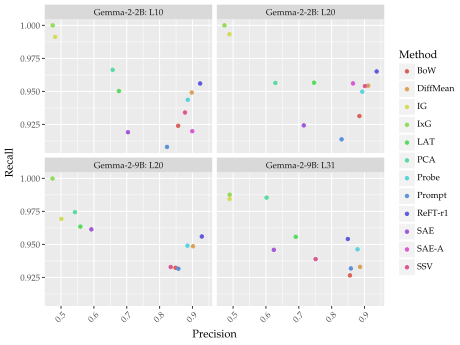

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_precision_vs_recall.pdf


In [13]:
%config InlineBackend.figure_format = 'svg'

# plot precision vs recall
split = "concept500"
df_subset = df.copy()
df_subset = df_subset[["Method", "model", "layer", "identifier", "Precision", "Recall"]]
df_subset = df_subset.dropna(subset=["Precision", "Recall"])
df_subset = df_subset.groupby(["identifier", "Method", "model", "layer"]).mean().reset_index()
plot = (
    ggplot(df_subset, aes(x="Precision", y="Recall", color="Method"))
    + facet_wrap('model + ": " + layer')
    + geom_point()
    + labs(x="Precision", y="Recall")
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_precision_vs_recall.pdf", width=4, height=3)

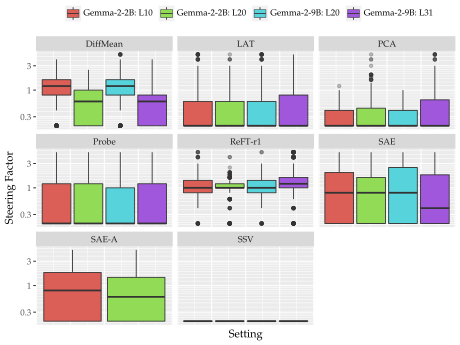

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_best_factor.pdf


In [14]:
# plot max_factor
df_subset = df.copy()
df_subset = df_subset.dropna(subset=["Steering Factor"])
df_subset = df_subset[~df_subset["Method"].isin(no_factor)]
# df_subset = df_subset.groupby(["Method", "model", "layer", "Steering Factor"]).count().reset_index()
# print(df_subset)
plot = (
    ggplot(df_subset, aes(y="Steering Factor", fill='model + ": " + layer'))
    + geom_boxplot(outlier_alpha=0.3)
    + facet_wrap("Method")
    # + geom_violin()
    # + stat_count(geom="point")
    + labs(x="Setting", y="Steering Factor", fill="")
    + scale_y_log10()
    + theme(legend_position="top", axis_text_x=element_blank(), axis_ticks_x=element_blank())
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_best_factor.pdf", width=6, height=4)

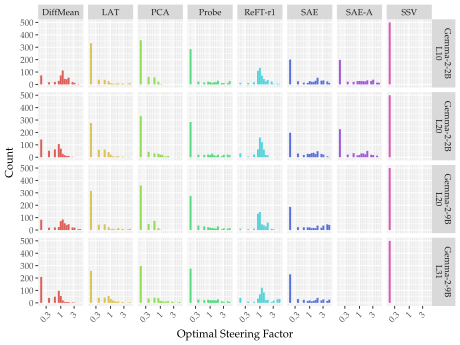

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_optimal_factor.pdf


In [15]:
# plot max_factor
df_subset = df.copy()
df_subset = df_subset.dropna(subset=["Steering Factor"])
df_subset = df_subset[~df_subset["Method"].isin(no_factor)]
# df_subset = df_subset.groupby(["Method", "model", "layer", "Steering Factor"]).count().reset_index()
# print(df_subset)
plot = (
    ggplot(df_subset, aes(x="Steering Factor", fill="Method"))
    + geom_histogram(bins=21)
    + facet_grid('model + layer ~ Method')
    # + geom_violin()
    # + stat_count(geom="point")
    + labs(x="Optimal Steering Factor", y="Count", fill="")
    + scale_x_log10()
    + theme(legend_position="none")
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_optimal_factor.pdf", width=8, height=4)

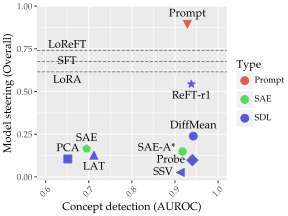

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_summary.pdf


In [16]:
# plot AUROC vs max lm judge rating
df_subset = df.copy()
df_subset = df_subset[["Method", "model", "layer", "identifier", "AUROC", "Overall Score"]]
df_subset2 = df_subset.dropna(subset=["AUROC", "Overall Score"])
df_subset2 = df_subset2.groupby(["identifier", "Method", "model", "layer"]).mean().reset_index()
df_subset2 = df_subset2[["Method", "AUROC", "Overall Score"]].groupby(["Method"]).mean().reset_index()
df_subset2["Color"] = df_subset2["Method"].map({
    "Prompt": "Prompt",
    "LoReFT": "Finetuning",
    "LoRA": "Finetuning",
    "SFT": "Finetuning",
    "SAE": "SAE",
    "SAE-A": "SAE",
    "ReFT-r1": "SDL",
    "DiffMean": "SDL",
    "Probe": "SDL",
    "SSV": "SDL",
    "LAT": "SDL",
    "PCA": "SDL",
})
# print(df_subset2)
plot = (
    ggplot(df_subset2, aes(x="AUROC", y="Overall Score", shape="Method", color="Color"))
    + geom_point(size=4)
    + geom_text(df_subset2[~df_subset2["Method"].isin(["LAT", "SAE-A", "Probe", "SSV", "ReFT-r1"])], aes(label="Method"), color="black", nudge_y=0.06)
    + geom_text(df_subset2[df_subset2["Method"].isin(["LAT", "ReFT-r1"])], aes(label="Method"), color="black", nudge_y=-0.07)
    + geom_text(df_subset2[df_subset2["Method"].isin(["SAE-A"])], label="SAE-A*", color="black", nudge_x=-0.06, nudge_y=0.02)
    + geom_text(df_subset2[df_subset2["Method"].isin(["Probe"])], aes(label="Method"), color="black", nudge_x=-0.05)
    + geom_text(df_subset2[df_subset2["Method"].isin(["SSV"])], aes(label="Method"), color="black", nudge_x=-0.04)
    + labs(x="Concept detection (AUROC)", y="Model steering (Overall)", color="Type")
    + theme(legend_position="right", figure_size=(4, 3))
    + xlim(0.6, 1)
    + guides(shape="none")
)
df_subset3 = df_subset[df_subset["Method"].isin(["LoReFT", "LoRA", "SFT"])].groupby(["identifier", "Method", "model", "layer"]).mean().reset_index()
df_subset3 = df_subset3[["Method", "AUROC", "Overall Score"]].groupby(["Method"]).mean().reset_index()
plot += geom_hline(df_subset3, aes(yintercept="Overall Score"), alpha=0.5, linetype="dashed")
plot += geom_text(df_subset3[~df_subset3["Method"].isin(["LoRA", "SFT"])], aes(label="Method", y="Overall Score"), x=0.65, color="black", nudge_y=0.03)
plot += geom_text(df_subset3[df_subset3["Method"].isin(["LoRA"])], aes(label="Method", y="Overall Score"), x=0.65, color="black", nudge_y=-0.05)
plot += geom_text(df_subset3[df_subset3["Method"].isin(["SFT"])], aes(label="Method", y="Overall Score"), x=0.65, color="black", nudge_y=0)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_summary.pdf", width=4, height=3)

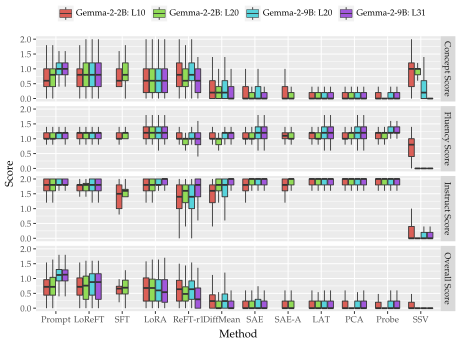

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 5 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_steering.pdf


In [17]:
# plot each steering metric
df_subset = df.copy()[["Method", "model", "layer", "identifier", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
df_subset = df_subset.dropna(subset=["Concept Score", "Instruct Score", "Fluency Score", "Overall Score", "model", "layer"])
df_subset = df_subset.melt(id_vars=["Method", "model", "layer", "identifier"], value_vars=["Concept Score", "Instruct Score", "Fluency Score", "Overall Score"], var_name="metric", value_name="value")
df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=[x for x in steering_order if x not in ignore])
plot = (
    ggplot(df_subset, aes(x="Method", y="value", fill='model + ": " + layer'))
    + facet_grid("metric~")
    # + facet_grid("model + layer ~")
    # + stat_summary(fun_data="mean_cl_boot", geom="bar", position="dodge")
    + geom_boxplot(outlier_shape="", position=position_dodge2(preserve="single"))
    # + geom_violin(position=position_dodge2())
    + labs(fill="", y="Score")
    + theme(legend_position="top", axis_text_x=element_text(angle=0, hjust=0.5))
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_steering.pdf", width=10, height=5)

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


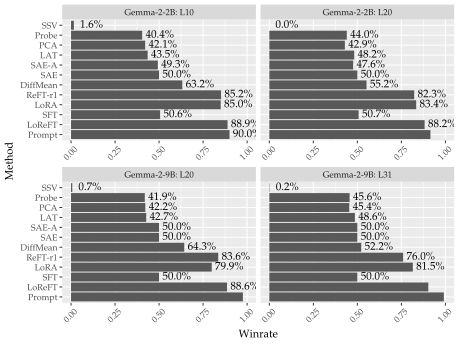

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 5 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_winrate.pdf
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 4 rows containing missing values.


In [18]:
# plot winrates
df_subset = df.copy()
df_subset = df_subset.dropna(subset=["Overall Score"])
methods = df_subset["Method"].unique()
df_subset = df_subset.pivot(index=id_vars, columns="Method", values="Overall Score").reset_index()
# print(df_subset)
def winrate(row, method):
    if not isinstance(row[method], (float, int)) or not isinstance(row["SAE"], (float, int)):
        return np.nan
    return 1.0 if row[method] > row["SAE"] else 0.0 if row[method] < row["SAE"] else 0.5
for method in methods:
    df_subset[method] = df_subset.apply(lambda row: winrate(row, method), axis=1)
df_subset = df_subset.melt(id_vars=id_vars, value_vars=methods, var_name="Method", value_name="Winrate")
df_subset["Count"] = 1
df_subset = df_subset.groupby(["Method", "identifier", "model", "layer", "split"]).sum().reset_index()
df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=steering_order)
df_subset["Winrate"] = df_subset["Winrate"] / df_subset["Count"]
df_subset["Text"] = df_subset["Winrate"].apply(lambda x: f"{x:.1%}")
df_subset = df_subset.dropna()
plot = (
    ggplot(df_subset, aes(y="Winrate", x="Method"))
    + facet_wrap('model + ": " + layer', scales="free_x")
    + geom_bar(stat="identity", position="stack")
    + geom_text(aes(label="Text", x="Method", y="Winrate"), position=position_stack(vjust=1.0), nudge_y=0.1)
    + labs(x="Method", y="Winrate")
    + coord_flip()
    + ylim(0, 1)
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_winrate.pdf", width=8, height=5)

In [19]:
# plot factor vs score
factor_df = df_all.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df = factor_df[~factor_df["Method"].isin(no_factor)]
factors = [val for val in factor_df["factor"]]
factor_dict = {
    "Steering Factor": [x for val in factor_df["factor"] for x in val],
    "Overall Score": [x for val in factor_df["lm_judge_rating"] for x in val],
    "Concept Score": [x for val in factor_df["relevance_concept_ratings"] for x in val],
    "Instruct Score": [x for val in factor_df["relevance_instruction_ratings"] for x in val],
    "Fluency Score": [x for val in factor_df["fluency_ratings"] for x in val],
}
lens = [len(val) for val in factors]
for col in id_vars + ["Method"]:
    factor_dict[col] = [val for i, val in enumerate(factor_df[col]) for _ in range(lens[i])]
factor_df_og = pd.DataFrame(factor_dict)
factor_df_og["Method"] = pd.Categorical(factor_df_og["Method"], categories=[x for x in steering_order if x not in no_factor])

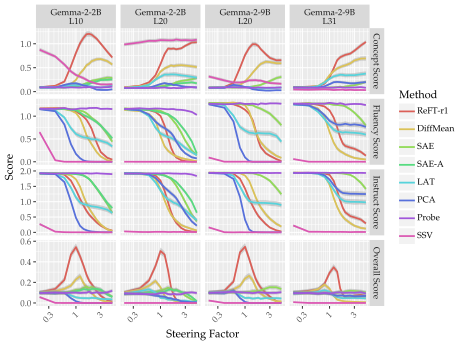

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 6 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_steering_factor.pdf


In [20]:
# plot factor vs score
factor_df = df.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df = factor_df[~factor_df["Method"].isin(no_factor)]
factors = [val for val in factor_df["factor"]]
factor_dict = {
    "Steering Factor": [x for val in factor_df["factor"] for x in val],
    "Overall Score": [x for val in factor_df["lm_judge_rating"] for x in val],
    "Concept Score": [x for val in factor_df["relevance_concept_ratings"] for x in val],
    "Instruct Score": [x for val in factor_df["relevance_instruction_ratings"] for x in val],
    "Fluency Score": [x for val in factor_df["fluency_ratings"] for x in val],
}
lens = [len(val) for val in factors]
for col in id_vars + ["Method"]:
    factor_dict[col] = [val for i, val in enumerate(factor_df[col]) for _ in range(lens[i])]
factor_df_og = pd.DataFrame(factor_dict)
factor_df_og["Method"] = pd.Categorical(factor_df_og["Method"], categories=[x for x in steering_order if (x not in no_factor) and (x not in ignore)])
factor_df = factor_df_og.melt(id_vars=id_vars + ["Method", "Steering Factor"], value_vars=["Overall Score", "Concept Score", "Instruct Score", "Fluency Score"], var_name="metric", value_name="value")
plot = (
    ggplot(factor_df, aes(x="Steering Factor", y="value", color="Method"))
    + stat_summary(fun_data="mean_cl_boot", geom="smooth")
    + scale_x_log10()
    + facet_grid("metric~model + layer", scales="free_y")
    + labs(x="Steering Factor", y="Score")
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_steering_factor.pdf", width=8, height=6)

/tmp/aryaman/ipykernel_1831244/3948226469.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


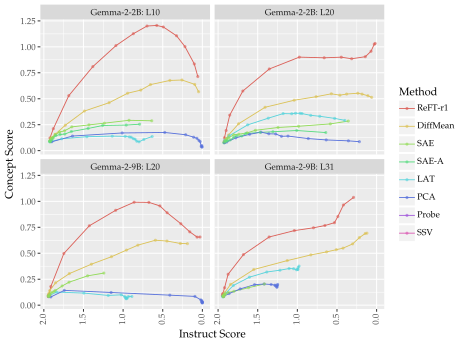

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 2.5 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_concept_vs_instruct.pdf


In [21]:
 # concept score vs instruct score for each method
factor_df_subset = factor_df_og[["Method", "model", "layer", "identifier", "Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
factor_df_subset = factor_df_subset.groupby(["Method", "model", "layer", "identifier", "Steering Factor"]).mean().reset_index()
factor_df_subset = factor_df_subset.dropna(subset=["Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"])
factor_df_subset = factor_df_subset.sort_values(by="Steering Factor").reset_index()
factor_df_subset = factor_df_subset[~factor_df_subset["Method"].isin(["SSV", "Probe"])]
plot = (
    ggplot(factor_df_subset, aes(x="Instruct Score", y="Concept Score"))
    + facet_wrap('model + ": " + layer')
    + geom_path(aes(color="Method", group="Method")) # arrow=arrow(type="closed", length=0.05)
    + geom_point(aes(color="Method"), alpha=0.5, size=0.8)
    # + geom_text(aes(label="Steering Factor", size=0.2), alpha=0.5, nudge_y=0.04)
    + scale_x_reverse()
    + theme(axis_text_x=element_text(angle=90, hjust=0.5))
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_concept_vs_instruct.pdf", width=4, height=2.5)

In [22]:
# make a new df from the lists roc_curve.fpr and roc_curve.tpr
common_fpr = np.linspace(0, 1, 38)
roc_df = df.copy().dropna(subset=["roc_curve.fpr", "roc_curve.tpr"])
fprs = [val for val in roc_df["roc_curve.fpr"]]
tprs = [val for val in roc_df["roc_curve.tpr"]]
for i in range(len(fprs)):
    tprs[i] = [0.0] + list(np.interp(common_fpr, fprs[i], tprs[i]))
    fprs[i] = [0.0] + list(common_fpr)
roc_dict = {
    "fpr": [x for val in fprs for x in val],
    "tpr": [x for val in tprs for x in val],
}
# for key in ["fpr", "tpr"]:
#     for val in roc_df[f"roc_curve.{key}"]:
#         vals = []
#         for x in val:
#             if len(vals) != 0:
#                 if key == "fpr": vals.append(x)
#                 else: vals.append(vals[-1])
#             vals.append(x)
#         roc_dict[key].extend(vals)
lens = [len(val) for val in fprs]
for col in id_vars + ["Method"]:
    roc_dict[col] = [val for i, val in enumerate(roc_df[col]) for _ in range(lens[i])]
roc_df = pd.DataFrame(roc_dict)
roc_mean_df = roc_df.groupby(['model', 'layer', 'split', 'identifier', 'Method', 'fpr']).mean().reset_index()
roc_mean_df["Method"] = pd.Categorical(roc_mean_df["Method"], categories=detection_order)
roc_df["Method"] = pd.Categorical(roc_df["Method"], categories=detection_order)
print("Main ROC DF", len(roc_df))
print("Mean ROC DF", len(roc_mean_df))

Main ROC DF 897000
Mean ROC DF 1748


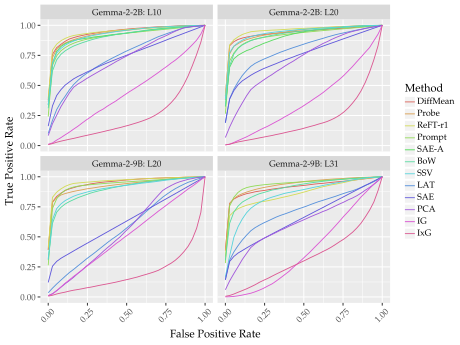

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_roc_mean.pdf


In [23]:
plot = (
    ggplot(roc_mean_df, aes(x="fpr", y="tpr", color="Method", group="Method"))
    + facet_wrap('model + ": " + layer')
    + geom_line()
    + labs(x="False Positive Rate", y="True Positive Rate")
    + theme(legend_key_size=10)
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_roc_mean.pdf", width=4, height=3)

In [24]:
 plot = (
    ggplot(roc_df[(roc_df["model"] == "Gemma-2-2B") & (roc_df["layer"] == "L10")], aes(x="fpr", y="tpr", color="Method", group="concept_id"))
    + facet_grid("model + layer ~ Method")
    + geom_line(alpha=0.1)
    # + stat_summary(fun_data="mean_cl_boot", geom="line", color="black")
    + labs(x="False Positive Rate", y="True Positive Rate")
    + theme(legend_position="none", axis_text_x=element_text(angle=90, hjust=0.5))
)
# Add average ROC curve to the plot
plot += geom_line(roc_mean_df[(roc_mean_df["model"] == "Gemma-2-2B") & (roc_mean_df["layer"] == "L10")], aes(x="fpr", y="tpr"), color="black", size=1.0, alpha=0.5)
# plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_roc.pdf", width=11, height=1.75)

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 11 x 1.75 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_roc.pdf


In [25]:
plot = (
    ggplot(roc_df, aes(x="fpr", y="tpr", color="Method", group="concept_id"))
    + facet_grid("model + layer ~ Method")
    + geom_line(alpha=0.1)
    # + stat_summary(fun_data="mean_cl_boot", geom="line", color="black")
    + labs(x="False Positive Rate", y="True Positive Rate")
    + theme(legend_position="none")
)
# Add average ROC curve to the plot
plot += geom_line(roc_mean_df, aes(x="fpr", y="tpr"), color="black", size=1.0, alpha=0.5)
# plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_roc_all.pdf", width=11, height=5)

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 11 x 5 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_roc_all.pdf


In [26]:
# make a plot for each metric
if False:
    for metric in FLOAT_METRICS:
        metric_name = METRIC_MAP[metric]
        plot = (
            ggplot(
                df.dropna(subset=[metric_name]),
                aes(x="Method", y=metric_name, fill="layer")
            )
            + facet_grid("~model")
            + geom_boxplot(outlier_alpha=0.3)
            + labs(x="Method", y=metric_name)
            + ylim(min(0, df[metric_name].min()), max(1, df[metric_name].max()))
        )
        plot.save(f"{PLOT_FOLDER}/{split}_{metric}.pdf", width=8, height=5)
    
    # Make scatter plots comparing each pair of float metrics
    if pairs:
        for metric1, metric2 in itertools.combinations(FLOAT_METRICS, 2):
            metric1_name = METRIC_MAP[metric1]
            metric2_name = METRIC_MAP[metric2]
            
            plot = (
                ggplot(
                    df.dropna(subset=[metric1_name, metric2_name]),
                    aes(x=metric1_name, y=metric2_name, color="layer")
                )
                + facet_grid("identifier ~ Method")
                + geom_point(alpha=0.5)
                + labs(x=metric1_name, y=metric2_name)
                + theme(legend_position="right")
            )
            plot.save(f"{PLOT_FOLDER}/{split}_{metric1}_vs_{metric2}.pdf", width=12, height=8)

## Imbalanced dataset evals

In [27]:
balance_results_dfs = []
for results_folder in RESULTS_FOLDERS:
    for folder in SUBFOLDERS:
        parts = folder.split("_")
        assert len(parts) == 4
        _, model, layer, split = parts
        dfs = []
        for method in METHODS:
            inference_folder = f"{results_folder}/{folder}_{method}/inference"
            imbalanced_inference_folder = f"{results_folder}/{folder}_{method}/inference_imbalance"
            print(inference_folder)
            if not os.path.exists(imbalanced_inference_folder):
                continue
    
            # collect inference results on large negative set
            df_generator = data_generator(inference_folder, mode="latent")
            method_dfs = []
            for concept_id, temp_df in df_generator:
                method_dfs.append(temp_df)
    
            # compute metrics when combining original balanced dataset with new large negative set
            for m in METHOD_MAP:
                imbalanced_data = f"{imbalanced_inference_folder}/{m}_latent_results.pkl"
                if os.path.exists(imbalanced_data):
                    # load the imbalanced data
                    with open(imbalanced_data, "rb") as f:
                        neg_data = pickle.load(f)
                    data = np.array(neg_data["max_act"])
                    print(data.shape)
                    neg_df = pd.DataFrame(data)
                    neg_df = pd.melt(neg_df, id_vars=None)
                    neg_df = neg_df.rename(columns={"variable": "concept"})
                elif os.path.exists(f"{imbalanced_inference_folder}/{m}_concept_0_latent_results.pkl"):
                    print("entering loop mode B-)")
                    neg_dfs = []
                    for c in tqdm(range(500)):
                        imbalanced_data = f"{imbalanced_inference_folder}/{m}_concept_{c}_latent_results.pkl"
                        if not os.path.exists(imbalanced_data):
                            print(f"couldn't find {imbalanced_data}")
                            continue
                        with open(imbalanced_data, "rb") as f:
                            neg_data = pickle.load(f)
                        data = np.array(neg_data["max_act"])
                        neg_df = pd.DataFrame(data)
                        neg_df = pd.melt(neg_df, id_vars=None)
                        neg_df = neg_df.rename(columns={"variable": "concept"})
                        neg_df["concept"] = c
                        neg_dfs.append(neg_df)
                    neg_df = pd.concat(neg_dfs)
                else:
                    continue
                print(imbalanced_data, f"METHOD: {m}")
                evaluator = LatentStatsEvaluator(m)
                
                results, orig_results = [], []
                for concept in tqdm(range(500)):
                    pos_df = method_dfs[concept]
                    add_df = neg_df[neg_df["concept"] == concept][["value"]].copy()
                    add_df["category"] = "negative"
                    add_df = add_df.rename(columns={"value": f"{m}_max_act"})
                    if len(add_df) == 0:
                        print(f"skippinng {concept}")
                        continue
    
                    # compute combined vs. orig scores
                    if f"{m}_max_act" not in pos_df.columns:
                        continue
                    # if "prompt" in imbalanced_data:
                    #     print(Counter(pd.concat([pos_df, add_df])["category"]))
                    eval_result = evaluator.compute_metrics(pd.concat([pos_df, add_df]))
                    eval_result_orig = evaluator.compute_metrics(pos_df)
                    eval_result["concept_id"] = concept
                    eval_result_orig["concept_id"] = concept
                    results.append(eval_result)
                    orig_results.append(eval_result_orig)
    
                for name, subset in {"imbalanced": results, "balanced": orig_results}.items():
                    sub_df = pd.DataFrame.from_dict(subset)
                    # sub_result = sub_df.mean().to_dict()
                    # print(f"{m} ({name[:3]}.): {sub_result["f1"]:.4f} (f1), {sub_result["precision"]:.4f} (prec), {sub_result["recall"]:.4f} (rec), {sub_result["positive_accuracy"]:4f} (pos acc), {sub_result["negative_accuracy"]:4f} (neg acc)")
                    sub_df["balancing"] = name
                    sub_df["method"] = m
                    sub_df["model"] = model
                    sub_df["layer"] = layer
                    sub_df["split"] = split
                    sub_df["count"] = len(subset)
                    balance_results_dfs.append(sub_df)

/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_ig/inference
/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_lsreft/inference
/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_steering_vec/inference
/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_sft/inference
/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_probe/inference
/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_no_grad/inference
/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_crossfit/inference
/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_lora/inference
/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_loreft/inference
/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_prompt_detection/inference
/nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_sae_selection/inference
/nlp/scr/aryaman/pyreax/axbench/paper_

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.81it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_steering_vec/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_steering_vec/inference_imbalance/SteeringVector_latent_results.pkl METHOD: SteeringVector


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.26it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_sft/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_probe/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_probe/inference_imbalance/LinearProbe_latent_results.pkl METHOD: LinearProbe


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.48it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_no_grad/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_no_grad/inference_imbalance/DiffMean_latent_results.pkl METHOD: DiffMean


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 48.04it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_no_grad/inference_imbalance/PCA_latent_results.pkl METHOD: PCA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 48.42it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_no_grad/inference_imbalance/LAT_latent_results.pkl METHOD: LAT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 47.27it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_no_grad/inference_imbalance/GemmaScopeSAE_latent_results.pkl METHOD: GemmaScopeSAE


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.75it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_crossfit/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_lora/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_loreft/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_prompt_detection/inference
entering loop mode B-)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 41.95it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_prompt_detection/inference_imbalance/PromptDetection_concept_499_latent_results.pkl METHOD: PromptDetection


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.35it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_sae_selection/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_bow/inference
entering loop mode B-)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 84.44it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept500_bow/inference_imbalance/BoW_concept_499_latent_results.pkl METHOD: BoW


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 49.76it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_ig/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_lsreft/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_lsreft/inference_imbalance/LsReFT_latent_results.pkl METHOD: LsReFT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 48.80it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_steering_vec/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_steering_vec/inference_imbalance/SteeringVector_latent_results.pkl METHOD: SteeringVector


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 48.01it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_sft/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_probe/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_probe/inference_imbalance/LinearProbe_latent_results.pkl METHOD: LinearProbe


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 48.65it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_no_grad/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_no_grad/inference_imbalance/DiffMean_latent_results.pkl METHOD: DiffMean


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.80it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_no_grad/inference_imbalance/PCA_latent_results.pkl METHOD: PCA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.89it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_no_grad/inference_imbalance/LAT_latent_results.pkl METHOD: LAT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.49it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_no_grad/inference_imbalance/GemmaScopeSAE_latent_results.pkl METHOD: GemmaScopeSAE


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.67it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_crossfit/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_lora/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_loreft/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_prompt_detection/inference
entering loop mode B-)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.05it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_prompt_detection/inference_imbalance/PromptDetection_concept_499_latent_results.pkl METHOD: PromptDetection


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.82it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_sae_selection/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_bow/inference
entering loop mode B-)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 102.48it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept500_bow/inference_imbalance/BoW_concept_499_latent_results.pkl METHOD: BoW


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 49.65it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_ig/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_lsreft/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_lsreft/inference_imbalance/LsReFT_latent_results.pkl METHOD: LsReFT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.34it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_steering_vec/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_steering_vec/inference_imbalance/SteeringVector_latent_results.pkl METHOD: SteeringVector


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.71it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_sft/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_probe/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_probe/inference_imbalance/LinearProbe_latent_results.pkl METHOD: LinearProbe


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.74it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_no_grad/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_no_grad/inference_imbalance/DiffMean_latent_results.pkl METHOD: DiffMean


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 45.77it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_no_grad/inference_imbalance/PCA_latent_results.pkl METHOD: PCA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.06it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_no_grad/inference_imbalance/LAT_latent_results.pkl METHOD: LAT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 45.27it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_no_grad/inference_imbalance/GemmaScopeSAE_latent_results.pkl METHOD: GemmaScopeSAE


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.29it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_crossfit/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_lora/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_loreft/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_prompt_detection/inference
entering loop mode B-)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.31it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_prompt_detection/inference_imbalance/PromptDetection_concept_499_latent_results.pkl METHOD: PromptDetection


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.04it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_sae_selection/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_bow/inference
entering loop mode B-)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 97.77it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l20_concept500_bow/inference_imbalance/BoW_concept_499_latent_results.pkl METHOD: BoW


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.05it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_ig/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_lsreft/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_lsreft/inference_imbalance/LsReFT_latent_results.pkl METHOD: LsReFT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.53it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_steering_vec/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_steering_vec/inference_imbalance/SteeringVector_latent_results.pkl METHOD: SteeringVector


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.34it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_sft/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_probe/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_probe/inference_imbalance/LinearProbe_latent_results.pkl METHOD: LinearProbe


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.14it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_no_grad/inference
(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_no_grad/inference_imbalance/DiffMean_latent_results.pkl METHOD: DiffMean


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 48.80it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_no_grad/inference_imbalance/PCA_latent_results.pkl METHOD: PCA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 49.25it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_no_grad/inference_imbalance/LAT_latent_results.pkl METHOD: LAT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 48.56it/s]


(3600, 500)
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_no_grad/inference_imbalance/GemmaScopeSAE_latent_results.pkl METHOD: GemmaScopeSAE


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.47it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_crossfit/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_lora/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_loreft/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_prompt_detection/inference
entering loop mode B-)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.23it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_prompt_detection/inference_imbalance/PromptDetection_concept_499_latent_results.pkl METHOD: PromptDetection


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.38it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_sae_selection/inference
/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_bow/inference
entering loop mode B-)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 167.55it/s]


/nlp/scr/wuzhengx/pyreax/axbench/results/prod_9b_l31_concept500_bow/inference_imbalance/BoW_concept_499_latent_results.pkl METHOD: BoW


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.61it/s]


In [28]:
balance_df = pd.concat(balance_results_dfs)
print(len(balance_df))
balance_df.head()

36000


positive_accuracy  negative_accuracy  hard_negative_accuracy  precision  \
0           0.861111           1.000000                     1.0   1.000000   
1           0.916667           1.000000                     1.0   1.000000   
2           0.916667           0.998900                     1.0   0.891892   
3           1.000000           1.000000                     1.0   1.000000   
4           0.361111           0.966722                     1.0   0.097015   

     recall        f1  macro_avg_accuracy_fixed  overall_accuracy  \
0  0.861111  0.925373                  0.953704          0.998640   
1  0.916667  0.956522                  0.972222          0.999184   
2  0.916667  0.904110                  0.971856          0.998096   
3  1.000000  1.000000                  1.000000          1.000000   
4  0.361111  0.152941                  0.775944          0.960848   

   max_act_val  min_act_val  optimal_roc_threshold  optimal_pr_threshold  \
0        56.25        2.812               0.536846              0.621056   
1        78.00        0.000               0.288462              0.608974   
2        62.50        0.162               0.526773              0.635054   
3        70.00        0.118               0.585015              0.585015   
4        36.75        0.000               0.435374              0.863946   

   concept_id   balancing  method model layer       split  count  
0           0  imbalanced  LsReFT    2b   l10  concept500    500  
1           1  imbalanced  LsReFT    2b   l10  concept500    500  
2           2  imbalanced  LsReFT    2b   l10  concept500    500  
3           3  imbalanced  LsReFT    2b   l10  concept500    500  
4           4  imbalanced  LsReFT    2b   l10  concept500    500

In [29]:
balance_df["count"].unique()

array([500])

In [30]:
balance_df2 = prettify_df(balance_df)
balance_df2 = balance_df2[["Method", "model", "layer", "F1", "balancing"]]
balance_df2 = balance_df2.rename(columns={"F1": "values", "balancing": "Balanced?"})
balance_df2 = balance_df2.groupby(["Method", "model", "layer", "Balanced?"]).apply(mean_and_ci).reset_index()
balance_df2["Method"] = balance_df2["Method"].apply(lambda x: "Prompt" if x == "PromptDetection" else x)
balance_df2["Method"] = pd.Categorical(balance_df2["Method"], categories=["ReFT-r1", "DiffMean", "Probe", "SSV", "BoW", "Prompt", "LAT", "SAE", "PCA"])
balance_df2["mean_formatted"] = balance_df2["mean"].apply(lambda x: f"{x:.3f}")
balance_df2 = balance_df2.rename(columns={"mean": "F1"})
balance_df2

/tmp/aryaman/ipykernel_1831244/1459476232.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Method       model layer   Balanced?        F1  lower_ci  upper_ci  \
0     BoW  Gemma-2-2B   L10    balanced  0.881040  0.871845  0.890266   
1     BoW  Gemma-2-2B   L10  imbalanced  0.529009  0.505213  0.552953   
2     BoW  Gemma-2-2B   L20    balanced  0.902147  0.892903  0.910423   
3     BoW  Gemma-2-2B   L20  imbalanced  0.556807  0.534893  0.578727   
4     BoW  Gemma-2-9B   L20    balanced  0.879614  0.869871  0.890717   
..    ...         ...   ...         ...       ...       ...       ...   
67    SSV  Gemma-2-2B   L20  imbalanced  0.686841  0.660447  0.709160   
68    SSV  Gemma-2-9B   L20    balanced  0.872327  0.862937  0.881447   
69    SSV  Gemma-2-9B   L20  imbalanced  0.529055  0.505641  0.550322   
70    SSV  Gemma-2-9B   L31    balanced  0.825274  0.817009  0.833907   
71    SSV  Gemma-2-9B   L31  imbalanced  0.221493  0.209754  0.233068   

   mean_formatted  
0           0.881  
1           0.529  
2           0.902  
3           0.557  
4           0.880  
..            ...  
67          0.687  
68          0.872  
69          0.529  
70          0.825  
71          0.221  

[72 rows x 8 columns]

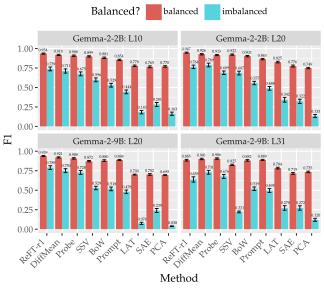

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.5 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_balance.pdf


In [31]:
plot = (
    ggplot(balance_df2, aes(x="Method", y="F1", fill="Balanced?"))
    + facet_wrap("model + ': ' + layer")
    + geom_bar(stat="identity", position=position_dodge(width=0.9))
    + geom_errorbar(aes(ymax="upper_ci", ymin="lower_ci"), position=position_dodge(width=0.9))
    + geom_text(balance_df2[balance_df2["Balanced?"] == "balanced"], aes(label="mean_formatted", y="upper_ci"), nudge_x=-0.25, nudge_y=0.035, size=4)
    + geom_text(balance_df2[balance_df2["Balanced?"] == "imbalanced"], aes(label="mean_formatted", y="upper_ci"), nudge_x=0.27, nudge_y=0.035, size=4)
    + theme(axis_text_x=element_text(hjust=1), legend_position="top", figure_size=(4.5, 4))
)
plot.show()
plot.save(f"{PLOT_FOLDER}/{split}_balance.pdf", width=4.5, height=4)

## Gen/Platonic

In [32]:
METHODS_GEN = [
    "lsreft_gen", "lsreft_platonic", "lsreft"
]
MAPPING_GEN = {
    "lsreft_gen": "ReFT-r1 (Gen)",
    "lsreft_platonic": "ReFT-r1 (affine)",
    "lsreft": "ReFT-r1",
}

In [33]:
# make plot folder if not exists
os.makedirs(PLOT_FOLDER, exist_ok=True)

all_dfs = []
for results_folder in RESULTS_FOLDERS:
    for folder in SUBFOLDERS:
        parts = folder.split("_")
        assert len(parts) == 4
        _, model, layer, split = parts
        dfs = []
        for method in METHODS_GEN:
            df = process_folder(results_folder, folder, method)
            if df is not None:
                # rename
                if method in MAPPING_GEN:
                    df = df.rename(columns=lambda x: x.replace("LsReFT", MAPPING_GEN[method]))
                dfs.append(df)
                print(len(df))
    
        # merge dfs based on concept_id column, pick the first one
        if len(dfs) == 0:
            continue
        df = pd.concat(dfs)
        # print(list(df.columns))
        # print("Duplicates:", len(df.duplicated(subset=["concept_id", "model", "layer"])))
        df = df.groupby("concept_id").first().reset_index()
        df["model"] = MODEL_MAP[model]
        df["layer"] = LAYER_MAP[layer]
        df["split"] = split
        df["identifier"] = f"{model}, {layer}, {split}"
        all_dfs.append(format_df(df))

# save df
df = pd.concat(all_dfs)

could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_lsreft_gen/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_lsreft_platonic/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_lsreft/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l20_concept500_lsreft_gen/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l20_concept500_lsreft_platonic/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l20_concept500_lsreft/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_9b_l20_concept500_lsreft_gen/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_9b_l20_concept500_lsreft_platonic/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_9b_l20_concept500_lsreft/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/

In [34]:
def winrate(row):
    method = "ReFT-r1"
    prompt_equivalent = df[(df["Method"] == method) & (df["identifier"] == row["identifier"]) & (df["concept_id"] == row["concept_id"])]
    if prompt_equivalent.empty:
        print(df[(df["Method"] == method)]["identifier"].unique())
    prompt_equivalent = prompt_equivalent.iloc[0]
    if not isinstance(row["Overall Score"], (float, int)) or not isinstance(prompt_equivalent["Overall Score"], (float, int)):
        return np.nan
    return 1.0 if row["Overall Score"] > prompt_equivalent["Overall Score"] else 0.0 if row["Overall Score"] < prompt_equivalent["Overall Score"] else 0.5

df["Winrate"] = df.apply(lambda row: winrate(row), axis=1)

In [35]:
# make latex table
detection_order = []
steering_order = []
for metric in ["AUROC", "Overall Score", "Winrate"]:
    for only_mean in [True, False]:
        df_subset: pd.DataFrame = df.copy().dropna(subset=[metric])
        df_subset = df_subset[df_subset["Method"].str.contains("ReFT-r1")]
        df_subset = df_subset.rename(columns={metric: "values"})[["Method", "identifier", "values"]]
        avg_df = df_subset.copy()
        avg_df["identifier"] = "Average"
        df_subset = pd.concat([df_subset, avg_df])
        df_subset = df_subset.groupby(["identifier", "Method"]).apply(mean_and_ci).reset_index()
        
        # Append the averages to the original dataframe
        df_subset["values"] = df_subset.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
        df_subset = df_subset.pivot(index="Method", columns="identifier", values="values").reset_index()
        df_subset = df_subset.sort_values(by="Average", ascending=False)

        # df_subset_avg = df.copy()
        # df_subset_avg = df_subset_avg.rename(columns={metric: "values"})
        # df_subset_avg = df_subset_avg[["Method", "identifier", "values"]].groupby(["Method"]).apply(mean_and_ci).reset_index()
        # df_subset_avg["values"] = df_subset_avg.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
        # df_subset["Average"] = df_subset.apply(lambda row: df_subset_avg[df_subset_avg["Method"] == row["Method"]]["values"].values[0], axis=1)
        # df_subset = df_subset.sort_values(by="Average", ascending=False)
        if metric == "AUROC":
            detection_order = df_subset["Method"].tolist()
        elif metric == "Overall Score":
            steering_order = df_subset["Method"].tolist()
        elif metric in ["Winrate"]:
            df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=steering_order, ordered=True)
        else:
            df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=detection_order, ordered=True)
        flattened = df_subset.to_latex(index=False)
        print(flattened)
        print("\n\n")

    # do paired t test on Latent AUROC between each pair of methods
    df_subset = df.copy()[["Method", "identifier", "concept_id", metric]]
    df_subset = df_subset.pivot(index=["identifier", "concept_id"], columns="Method", values=metric).reset_index()
    for identifier in list(df_subset["identifier"].unique()) + [None]:
        for method1, method2 in itertools.combinations([m for m in df["Method"].unique() if "ReFT-r1" in m], 2):
            df_subset_t = df_subset[df_subset["identifier"] == identifier] if identifier is not None else df_subset
            if method1 not in df_subset_t.columns or method2 not in df_subset_t.columns:
                continue
            roc_auc_1 = list(df_subset_t[method1])
            roc_auc_2 = list(df_subset_t[method2])
            # print all nans
            method1_nan = sum(np.isnan(roc_auc_1))
            method2_nan = sum(np.isnan(roc_auc_2))
            if method1_nan > 0 or method2_nan > 0:
                # print(f"{method1} vs {method2}: skipping: {method1_nan}, {method2_nan}")
                continue
            t_stat, p_value = ttest_rel(roc_auc_1, roc_auc_2, nan_policy="raise")
            print(f"{identifier}: {method1} vs {method2}: T-statistic: {t_stat}, P-value: {p_value} {'(Significant)' if p_value < 0.05 else ''}")

/tmp/aryaman/ipykernel_1831244/3246722664.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/aryaman/ipykernel_1831244/3246722664.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/aryaman/ipykernel_1831244/3246722664.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be exclud

\begin{tabular}{llllll}
\toprule
Method & 2b, l10, concept500 & 2b, l20, concept500 & 9b, l20, concept500 & 9b, l31, concept500 & Average \\
\midrule
ReFT-r1 (affine) & NaN & 0.954 & 0.974 & NaN & 0.964 \\
ReFT-r1 (Gen) & NaN & 0.945 & 0.965 & NaN & 0.955 \\
ReFT-r1 & 0.952 & 0.965 & 0.966 & 0.869 & 0.938 \\
\bottomrule
\end{tabular}




\begin{tabular}{llllll}
\toprule
Method & 2b, l10, concept500 & 2b, l20, concept500 & 9b, l20, concept500 & 9b, l31, concept500 & Average \\
\midrule
ReFT-r1 (affine) & NaN & 0.954$^{+0.007}_{-0.008}$ & 0.974$^{+0.003}_{-0.004}$ & NaN & 0.964$^{+0.004}_{-0.004}$ \\
ReFT-r1 (Gen) & NaN & 0.945$^{+0.009}_{-0.010}$ & 0.965$^{+0.005}_{-0.005}$ & NaN & 0.955$^{+0.005}_{-0.006}$ \\
ReFT-r1 & 0.952$^{+0.007}_{-0.008}$ & 0.965$^{+0.006}_{-0.008}$ & 0.966$^{+0.005}_{-0.006}$ & 0.869$^{+0.017}_{-0.016}$ & 0.938$^{+0.005}_{-0.006}$ \\
\bottomrule
\end{tabular}




2b, l20, concept500: ReFT-r1 vs ReFT-r1 (Gen): T-statistic: 4.085407740625499, P-value: 5.1255512833

/tmp/aryaman/ipykernel_1831244/3246722664.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/aryaman/ipykernel_1831244/3246722664.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/aryaman/ipykernel_1831244/3246722664.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be exclud

\begin{tabular}{llllll}
\toprule
Method & 2b, l10, concept500 & 2b, l20, concept500 & 9b, l20, concept500 & 9b, l31, concept500 & Average \\
\midrule
ReFT-r1 & 0.633$^{+0.034}_{-0.036}$ & 0.509$^{+0.032}_{-0.031}$ & 0.630$^{+0.035}_{-0.032}$ & 0.401$^{+0.032}_{-0.032}$ & 0.543$^{+0.018}_{-0.016}$ \\
ReFT-r1 (affine) & NaN & 0.444$^{+0.032}_{-0.032}$ & 0.541$^{+0.034}_{-0.032}$ & NaN & 0.493$^{+0.026}_{-0.023}$ \\
ReFT-r1 (Gen) & NaN & 0.415$^{+0.031}_{-0.030}$ & 0.466$^{+0.034}_{-0.033}$ & NaN & 0.440$^{+0.023}_{-0.023}$ \\
\bottomrule
\end{tabular}




2b, l20, concept500: ReFT-r1 vs ReFT-r1 (Gen): T-statistic: 6.092861442302496, P-value: 2.218906473362788e-09 (Significant)
2b, l20, concept500: ReFT-r1 vs ReFT-r1 (affine): T-statistic: 4.23516818034411, P-value: 2.719858932403566e-05 (Significant)
2b, l20, concept500: ReFT-r1 (Gen) vs ReFT-r1 (affine): T-statistic: -2.1321264675851026, P-value: 0.033484148028858934 (Significant)
9b, l20, concept500: ReFT-r1 vs ReFT-r1 (Gen): T-statist

## SAE Ablations

In [36]:
METHODS_ABL = [
    "no_grad", "gemmascope_clamp", "gemmascope_clamp_small_factor",
    "gemmascope_min_clamp", "gemmascope_axbench_max_act"
]
MAPPING_ABL = {
    "gemmascope_clamp": "SAE-c",
    "gemmascope_clamp_small_factor": "SAE-c (small factor)",
    "gemmascope_min_clamp": "SAE-c (min clamp)",
    "gemmascope_axbench_max_act": "SAE (max act)",
}

In [37]:
# make plot folder if not exists
os.makedirs(PLOT_FOLDER, exist_ok=True)

all_dfs = []
for results_folder in RESULTS_FOLDERS:
    for folder in SUBFOLDERS:
        parts = folder.split("_")
        assert len(parts) == 4
        _, model, layer, split = parts
        dfs = []
        for method in METHODS_ABL:
            df = process_folder(results_folder, folder, method)
            if df is not None:
                # rename
                if method in MAPPING_ABL:
                    df = df.rename(columns=lambda x: x.replace("GemmaScopeSAE", MAPPING_ABL[method]))
                dfs.append(df)
                print(len(df))
    
        # merge dfs based on concept_id column, pick the first one
        if len(dfs) == 0:
            continue
        df = pd.concat(dfs)
        # print(list(df.columns))
        # print("Duplicates:", len(df.duplicated(subset=["concept_id", "model", "layer"])))
        df = df.groupby("concept_id").first().reset_index()
        df["model"] = MODEL_MAP[model]
        df["layer"] = LAYER_MAP[layer]
        df["split"] = split
        df["identifier"] = f"{model}, {layer}, {split}"
        all_dfs.append(format_df(df))

# save df
df = pd.concat(all_dfs)

could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_no_grad/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_gemmascope_clamp/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_gemmascope_clamp_small_factor/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_gemmascope_min_clamp/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept500_gemmascope_axbench_max_act/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l20_concept500_no_grad/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l20_concept500_gemmascope_clamp/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l20_concept500_gemmascope_clamp_small_factor/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l20_concept500_gemmascope_min

In [38]:
df.groupby(["identifier", "Method"]).count()

concept_id  model  layer  split  \
identifier          Method                                                  
2b, l10, concept500 DiffMean                     500    500    500    500   
                    LAT                          500    500    500    500   
                    PCA                          500    500    500    500   
                    Prompt                       500    500    500    500   
                    SAE                          500    500    500    500   
                    SAE (max act)                500    500    500    500   
                    SAE-c                        500    500    500    500   
                    SAE-c (min clamp)            500    500    500    500   
                    SAE-c (small factor)         500    500    500    500   
2b, l20, concept500 DiffMean                     500    500    500    500   
                    LAT                          500    500    500    500   
                    PCA                          500    500    500    500   
                    Prompt                       500    500    500    500   
                    SAE                          500    500    500    500   
                    SAE (max act)                500    500    500    500   
                    SAE-c                        500    500    500    500   
                    SAE-c (min clamp)            500    500    500    500   
                    SAE-c (small factor)         500    500    500    500   
9b, l20, concept500 DiffMean                     500    500    500    500   
                    LAT                          500    500    500    500   
                    PCA                          500    500    500    500   
                    Prompt                       500    500    500    500   
                    SAE                          500    500    500    500   
                    SAE (max act)                500    500    500    500   
                    SAE-c                        500    500    500    500   
                    SAE-c (min clamp)            500    500    500    500   
9b, l31, concept500 DiffMean                     500    500    500    500   
                    LAT                          500    500    500    500   
                    PCA                          500    500    500    500   
                    Prompt                       500    500    500    500   
                    SAE                          500    500    500    500   
                    SAE (max act)                500    500    500    500   
                    SAE-c                        500    500    500    500   
                    SAE-c (min clamp)            500    500    500    500   

                                           F1  factor  factor_test  \
identifier          Method                                           
2b, l10, concept500 DiffMean              500     500          500   
                    LAT                   500     500          500   
                    PCA                   500     500          500   
                    Prompt                  0     500          500   
                    SAE                   500     500          500   
                    SAE (max act)         500     500          500   
                    SAE-c                 500     500          500   
                    SAE-c (min clamp)     500     500          500   
                    SAE-c (small factor)  500     500            0   
2b, l20, concept500 DiffMean              500     500          500   
                    LAT                   500     500          500   
                    PCA                   500     500          500   
                    Prompt                  0     500          500   
                    SAE                   500     500          500   
                    SAE (max act)         500     500          500   
                    SAE-c                 500     500          500   
         

In [39]:
def winrate(row):
    method = "SAE"
    prompt_equivalent = df[(df["Method"] == method) & (df["identifier"] == row["identifier"]) & (df["concept_id"] == row["concept_id"])]
    if prompt_equivalent.empty:
        print(df[(df["Method"] == method)]["identifier"].unique())
    prompt_equivalent = prompt_equivalent.iloc[0]
    if not isinstance(row["Overall Score"], (float, int)) or not isinstance(prompt_equivalent["Overall Score"], (float, int)):
        return np.nan
    return 1.0 if row["Overall Score"] > prompt_equivalent["Overall Score"] else 0.0 if row["Overall Score"] < prompt_equivalent["Overall Score"] else 0.5

df["Winrate"] = df.apply(lambda row: winrate(row), axis=1)

In [40]:
# make latex table
detection_order = []
steering_order = []
for metric in ["Overall Score", "Winrate"]:
    for only_mean in [True, False]:
        df_subset: pd.DataFrame = df.copy().dropna(subset=[metric])
        df_subset = df_subset[df_subset["Method"].str.contains("SAE")]
        df_subset = df_subset.rename(columns={metric: "values"})[["Method", "identifier", "values"]]
        avg_df = df_subset.copy()
        avg_df["identifier"] = "Average"
        df_subset = pd.concat([df_subset, avg_df])
        df_subset = df_subset.groupby(["identifier", "Method"]).apply(mean_and_ci).reset_index()
        
        # Append the averages to the original dataframe
        df_subset["values"] = df_subset.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
        df_subset = df_subset.pivot(index="Method", columns="identifier", values="values").reset_index()
        df_subset = df_subset.sort_values(by="Average", ascending=False)

        # df_subset_avg = df.copy()
        # df_subset_avg = df_subset_avg.rename(columns={metric: "values"})
        # df_subset_avg = df_subset_avg[["Method", "identifier", "values"]].groupby(["Method"]).apply(mean_and_ci).reset_index()
        # df_subset_avg["values"] = df_subset_avg.apply(lambda row: format_ci(row['mean'], row['lower_ci'], row['upper_ci'], only_mean, percent=(metric == "Winrate")), axis=1)
        # df_subset["Average"] = df_subset.apply(lambda row: df_subset_avg[df_subset_avg["Method"] == row["Method"]]["values"].values[0], axis=1)
        # df_subset = df_subset.sort_values(by="Average", ascending=False)
        if metric == "AUROC":
            detection_order = df_subset["Method"].tolist()
        elif metric == "Overall Score":
            steering_order = df_subset["Method"].tolist()
        elif metric in ["Winrate"]:
            df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=steering_order, ordered=True)
        else:
            df_subset["Method"] = pd.Categorical(df_subset["Method"], categories=detection_order, ordered=True)
        flattened = df_subset.to_latex(index=False)
        print(flattened)
        print("\n\n")

    # do paired t test on Latent AUROC between each pair of methods
    df_subset = df.copy()[["Method", "identifier", "concept_id", metric]]
    df_subset = df_subset.pivot(index=["identifier", "concept_id"], columns="Method", values=metric).reset_index()
    for identifier in list(df_subset["identifier"].unique()) + [None]:
        for method1, method2 in itertools.combinations([m for m in df["Method"].unique() if "SAE" in m], 2):
            df_subset_t = df_subset[df_subset["identifier"] == identifier] if identifier is not None else df_subset
            if method1 not in df_subset_t.columns or method2 not in df_subset_t.columns:
                continue
            roc_auc_1 = list(df_subset_t[method1])
            roc_auc_2 = list(df_subset_t[method2])
            # print all nans
            method1_nan = sum(np.isnan(roc_auc_1))
            method2_nan = sum(np.isnan(roc_auc_2))
            if method1_nan > 0 or method2_nan > 0:
                # print(f"{method1} vs {method2}: skipping: {method1_nan}, {method2_nan}")
                continue
            t_stat, p_value = ttest_rel(roc_auc_1, roc_auc_2, nan_policy="raise")
            print(f"{identifier}: {method1} vs {method2}: T-statistic: {t_stat}, P-value: {p_value} {'(Significant)' if p_value < 0.05 else ''}")

/tmp/aryaman/ipykernel_1831244/3230221233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


\begin{tabular}{llllll}
\toprule
Method & 2b, l10, concept500 & 2b, l20, concept500 & 9b, l20, concept500 & 9b, l31, concept500 & Average \\
\midrule
SAE & 0.177 & 0.151 & 0.191 & 0.140 & 0.165 \\
SAE (max act) & 0.166 & 0.150 & 0.163 & 0.128 & 0.152 \\
SAE-c (min clamp) & 0.074 & 0.072 & 0.123 & 0.090 & 0.090 \\
SAE-c & 0.063 & 0.061 & 0.126 & 0.120 & 0.088 \\
\bottomrule
\end{tabular}






/tmp/aryaman/ipykernel_1831244/3230221233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


\begin{tabular}{llllll}
\toprule
Method & 2b, l10, concept500 & 2b, l20, concept500 & 9b, l20, concept500 & 9b, l31, concept500 & Average \\
\midrule
SAE & 0.177$^{+0.026}_{-0.025}$ & 0.151$^{+0.023}_{-0.022}$ & 0.191$^{+0.024}_{-0.023}$ & 0.140$^{+0.021}_{-0.021}$ & 0.165$^{+0.011}_{-0.011}$ \\
SAE (max act) & 0.166$^{+0.025}_{-0.023}$ & 0.150$^{+0.023}_{-0.021}$ & 0.163$^{+0.024}_{-0.023}$ & 0.128$^{+0.021}_{-0.020}$ & 0.152$^{+0.011}_{-0.011}$ \\
SAE-c (min clamp) & 0.074$^{+0.014}_{-0.013}$ & 0.072$^{+0.013}_{-0.012}$ & 0.123$^{+0.019}_{-0.019}$ & 0.090$^{+0.018}_{-0.016}$ & 0.090$^{+0.008}_{-0.008}$ \\
SAE-c & 0.063$^{+0.012}_{-0.011}$ & 0.061$^{+0.013}_{-0.012}$ & 0.126$^{+0.018}_{-0.017}$ & 0.120$^{+0.026}_{-0.024}$ & 0.088$^{+0.008}_{-0.008}$ \\
\bottomrule
\end{tabular}




2b, l10, concept500: SAE vs SAE (max act): T-statistic: 1.2327345610445601, P-value: 0.21825526779483442 
2b, l10, concept500: SAE vs SAE-c: T-statistic: 10.962049366210517, P-value: 3.3518027383102272e-25 

/tmp/aryaman/ipykernel_1831244/3230221233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


\begin{tabular}{llllll}
\toprule
Method & 2b, l10, concept500 & 2b, l20, concept500 & 9b, l20, concept500 & 9b, l31, concept500 & Average \\
\midrule
SAE & 50.0\% & 50.0\% & 50.0\% & 50.0\% & 50.0\% \\
NaN & 50.0\% & 50.0\% & NaN & NaN & 50.0\% \\
SAE (max act) & 49.1\% & 49.8\% & 46.8\% & 47.5\% & 48.3\% \\
SAE-c & 36.3\% & 38.7\% & 42.1\% & 49.2\% & 41.6\% \\
SAE-c (min clamp) & 38.2\% & 40.1\% & 41.0\% & 42.8\% & 40.5\% \\
\bottomrule
\end{tabular}




\begin{tabular}{llllll}
\toprule
Method & 2b, l10, concept500 & 2b, l20, concept500 & 9b, l20, concept500 & 9b, l31, concept500 & Average \\
\midrule
SAE & 50.0\%$^{+0.000}_{-0.000}$ & 50.0\%$^{+0.000}_{-0.000}$ & 50.0\%$^{+0.000}_{-0.000}$ & 50.0\%$^{+0.000}_{-0.000}$ & 50.0\%$^{+0.000}_{-0.000}$ \\
NaN & 50.0\%$^{+0.000}_{-0.000}$ & 50.0\%$^{+0.000}_{-0.000}$ & NaN & NaN & 50.0\%$^{+0.000}_{-0.000}$ \\
SAE (max act) & 49.1\%$^{+0.029}_{-0.029}$ & 49.8\%$^{+0.025}_{-0.026}$ & 46.8\%$^{+0.030}_{-0.030}$ & 47.5\%$^{+0.025}_{-0.025}$ & 

/tmp/aryaman/ipykernel_1831244/3230221233.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [41]:
# plot factor vs score
factor_df = df.copy()
factor_df = factor_df.dropna(subset=["factor"])
factor_df = factor_df[~factor_df["Method"].isin(no_factor)]
factors = [val for val in factor_df["factor"]]
factor_dict = {
    "Steering Factor": [x for val in factor_df["factor"] for x in val],
    "Overall Score": [x for val in factor_df["lm_judge_rating"] for x in val],
    "Concept Score": [x for val in factor_df["relevance_concept_ratings"] for x in val],
    "Instruct Score": [x for val in factor_df["relevance_instruction_ratings"] for x in val],
    "Fluency Score": [x for val in factor_df["fluency_ratings"] for x in val],
}
lens = [len(val) for val in factors]
for col in id_vars + ["Method"]:
    factor_dict[col] = [val for i, val in enumerate(factor_df[col]) for _ in range(lens[i])]
factor_df_og = pd.DataFrame(factor_dict)
factor_df_og["Method"] = pd.Categorical(factor_df_og["Method"], categories=[x for x in steering_order if x not in no_factor])

/tmp/aryaman/ipykernel_1831244/3479681230.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


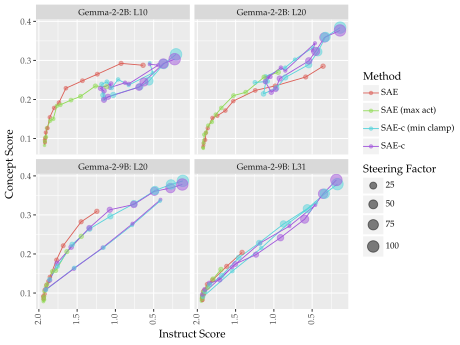

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_instruct_vs_concept_saec.pdf


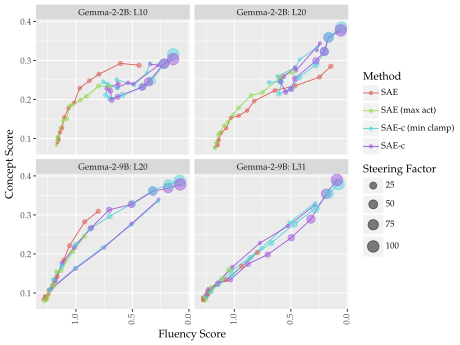

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_fluency_vs_concept_saec.pdf


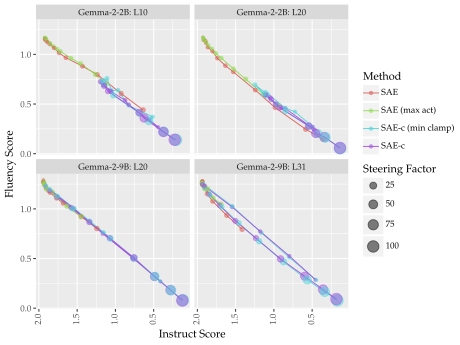

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_instruct_vs_fluency_saec.pdf


In [42]:
sae_methods = ["SAE", "SAE (max act)", "SAE-c (min clamp)", "SAE-c"]
factor_df_subset = factor_df_og[["Method", "model", "layer", "identifier", "Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
factor_df_subset = factor_df_subset.groupby(["Method", "model", "layer", "identifier", "Steering Factor"]).mean().reset_index()
factor_df_subset = factor_df_subset.dropna(subset=["Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"])
factor_df_subset = factor_df_subset.sort_values(by="Steering Factor").reset_index()
factor_df_subset = factor_df_subset[factor_df_subset["Method"].isin(sae_methods)]
factor_df_subset["Method"] = pd.Categorical(factor_df_subset["Method"], categories=[x for x in steering_order if x in sae_methods])

for (x, y) in [("Instruct Score", "Concept Score"), ("Fluency Score", "Concept Score"), ("Instruct Score", "Fluency Score")]:
    plot = (
        ggplot(factor_df_subset, aes(x=x, y=y))
        + facet_wrap('model + ": " + layer')
        + geom_path(aes(color="Method", group="Method")) # arrow=arrow(type="closed", length=0.05)
        + geom_point(aes(color="Method", size="Steering Factor"), alpha=0.5)
        # + geom_text(aes(label="Steering Factor", size=0.2), alpha=0.5, nudge_y=0.04)
        + scale_x_reverse()
        + theme(axis_text_x=element_text(angle=90, hjust=0.5))
    )
    plot.show()
    plot.save(f"{PLOT_FOLDER}/{split}_{x.split()[0].lower()}_vs_{y.split()[0].lower()}_saec.pdf", width=6, height=4)

/tmp/aryaman/ipykernel_1831244/801621087.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


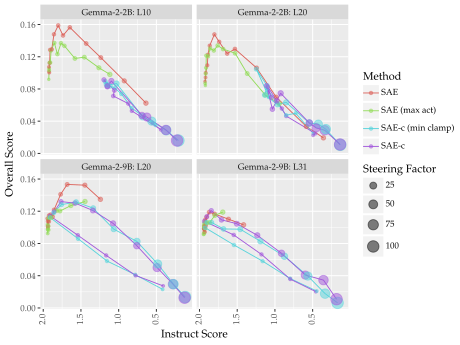

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept500_instruct_vs_overall_saec.pdf


In [43]:
sae_methods = ["SAE", "SAE (max act)", "SAE-c (min clamp)", "SAE-c"]
factor_df_subset = factor_df_og[["Method", "model", "layer", "identifier", "Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"]]
factor_df_subset = factor_df_subset.groupby(["Method", "model", "layer", "identifier", "Steering Factor"]).mean().reset_index()
factor_df_subset = factor_df_subset.dropna(subset=["Steering Factor", "Concept Score", "Instruct Score", "Fluency Score", "Overall Score"])
factor_df_subset = factor_df_subset.sort_values(by="Steering Factor").reset_index()
factor_df_subset = factor_df_subset[factor_df_subset["Method"].isin(sae_methods)]
factor_df_subset["Method"] = pd.Categorical(factor_df_subset["Method"], categories=[x for x in steering_order if x in sae_methods])

for (x, y) in [("Instruct Score", "Overall Score")]:
    plot = (
        ggplot(factor_df_subset, aes(x=x, y=y))
        + facet_wrap('model + ": " + layer')
        + geom_path(aes(color="Method", group="Method")) # arrow=arrow(type="closed", length=0.05)
        + geom_point(aes(color="Method", size="Steering Factor"), alpha=0.5)
        # + geom_text(aes(label="Steering Factor", size=0.2), alpha=0.5, nudge_y=0.04)
        + scale_x_reverse()
        + theme(axis_text_x=element_text(angle=90, hjust=0.5))
    )
    plot.show()
    plot.save(f"{PLOT_FOLDER}/{split}_{x.split()[0].lower()}_vs_{y.split()[0].lower()}_saec.pdf", width=6, height=4)

## SDL with limited data

In [44]:
!ls /nlp/scr/wuzhengx/pyreax/axbench/results/

prod_2b_l10_concept10_lsreft_scaling_law_120_42
prod_2b_l10_concept10_lsreft_scaling_law_120_43
prod_2b_l10_concept10_lsreft_scaling_law_120_44
prod_2b_l10_concept10_lsreft_scaling_law_12_42
prod_2b_l10_concept10_lsreft_scaling_law_12_43
prod_2b_l10_concept10_lsreft_scaling_law_12_44
prod_2b_l10_concept10_lsreft_scaling_law_144_42
prod_2b_l10_concept10_lsreft_scaling_law_144_43
prod_2b_l10_concept10_lsreft_scaling_law_144_44
prod_2b_l10_concept10_lsreft_scaling_law_24_42
prod_2b_l10_concept10_lsreft_scaling_law_24_43
prod_2b_l10_concept10_lsreft_scaling_law_24_44
prod_2b_l10_concept10_lsreft_scaling_law_48_42
prod_2b_l10_concept10_lsreft_scaling_law_48_43
prod_2b_l10_concept10_lsreft_scaling_law_48_44
prod_2b_l10_concept10_lsreft_scaling_law_6_42
prod_2b_l10_concept10_lsreft_scaling_law_6_43
prod_2b_l10_concept10_lsreft_scaling_law_6_44
prod_2b_l10_concept10_lsreft_scaling_law_72_42
prod_2b_l10_concept10_lsreft_scaling_law_72_43
prod_2b_l10_concept10_lsreft_scaling_law_72_44
prod_2b_l1

In [45]:
import glob

METHODS_SDL = ["lsreft_scaling_law" + x.split("/")[-1].split("lsreft_scaling_law")[-1] for x in glob.glob("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l10_concept10_lsreft_scaling_law*")]
SUBFOLDERS_SDL = [
    "prod_2b_l10_concept10",
    "prod_2b_l20_concept10",
    "prod_9b_l20_concept10",
    "prod_9b_l31_concept10",
    # "prod_2b_l20_concept16k",
    # "prod_9b_l20_concept16k",
]

In [46]:
# make plot folder if not exists
os.makedirs(PLOT_FOLDER, exist_ok=True)

all_dfs = []
for results_folder in RESULTS_FOLDERS:
    for folder in SUBFOLDERS_SDL:
        parts = folder.split("_")
        assert len(parts) == 4
        _, model, layer, split = parts
        dfs = []
        for method in METHODS_SDL:
            df = process_folder(results_folder, folder, method)
            if df is not None:
                # rename
                df = df.rename(columns=lambda x: x.replace("LsReFT", "LsReFT_" + "_".join(method.split("_")[-2:])))
                dfs.append(df)
                print(len(df))
    
        # merge dfs based on concept_id column, pick the first one
        if len(dfs) == 0:
            continue
        df = pd.concat(dfs)
        # print(list(df.columns))
        # print("Duplicates:", len(df.duplicated(subset=["concept_id", "model", "layer"])))
        df = df.groupby("concept_id").first().reset_index()
        df["model"] = MODEL_MAP[model]
        df["layer"] = LAYER_MAP[layer]
        df["split"] = split
        df["identifier"] = f"{model}, {layer}, {split}"
        all_dfs.append(format_df(df))

# save df
df = pd.concat(all_dfs)

could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept10_lsreft_scaling_law_72_43/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept10_lsreft_scaling_law_144_44/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept10_lsreft_scaling_law_48_44/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept10_lsreft_scaling_law_120_43/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept10_lsreft_scaling_law_120_44/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept10_lsreft_scaling_law_48_43/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept10_lsreft_scaling_law_144_43/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/prod_2b_l10_concept10_lsreft_scaling_law_6_42/evaluate
could not find /nlp/scr/aryaman/pyreax/axbench/paper_results/

In [47]:
df["# Examples"] = df["Method"].apply(lambda x: int(x.split("_")[-2]))
df["seed"] = df["Method"].apply(lambda x: int(x.split("_")[-1]))
df["Method"] = "LsReFT"
df.head()

concept_id       model layer      split          identifier  Method  \
0           0  Gemma-2-2B   L10  concept10  2b, l10, concept10  LsReFT   
1           0  Gemma-2-2B   L10  concept10  2b, l10, concept10  LsReFT   
2           0  Gemma-2-2B   L10  concept10  2b, l10, concept10  LsReFT   
3           0  Gemma-2-2B   L10  concept10  2b, l10, concept10  LsReFT   
4           0  Gemma-2-2B   L10  concept10  2b, l10, concept10  LsReFT   

         F1                                             factor  \
0  0.985915  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   
1  0.985915  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   
2  0.985915  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   
3  0.923077  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   
4  0.686275  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   

                                         factor_test  \
0  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   
1  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   
2  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   
3  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   
4  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, ...   

                                 fluency_completions  ...  \
0  [The sentence fragment begins with a clear and...  ...   
1  [The fluency of the sentence fragment is gener...  ...   
2  [The fluency of the provided sentence fragment...  ...   
3  [The sentence fragment exhibits good fluency o...  ...   
4  [The fluency of the provided sentence fragment...  ...   

                                            strength  \
0  [11.200000166893005, 22.40000033378601, 33.600...   
1  [11.250000167638063, 22.500000335276127, 33.75...   
2  [10.900000162422657, 21.800000324845314, 32.70...   
3  [13.600000202655792, 27.200000405311584, 40.80...   
4  [14.70000021904707, 29.40000043809414, 44.1000...   

                                       strength_test max_lm_judge_rating_idx  \
0  [11.200000166893005, 22.40000033378601, 33.600...                       4   
1  [11.250000167638063, 22.500000335276127, 33.75...                       4   
2  [10.900000162422657, 21.800000324845314, 32.70...                       5   
3  [13.600000202655792, 27.200000405311584, 40.80...                       2   
4  [14.70000021904707, 29.40000043809414, 44.1000...                       5   

  Overall Score Fluency Score Concept Score  Instruct Score Steering Factor  \
0          0.70           1.2           0.6             1.4             1.0   
1          1.08           1.0           1.2             1.2             1.0   
2          0.70           1.0           1.4             0.8             1.2   
3          0.00           1.4           0.0             1.6             0.6   
4          0.70           1.0           1.0             1.2             1.2   

   # Examples  seed  
0         120    42  
1         120    43  
2         120    44  
3          12    42  
4          12    43  

[5 rows x 60 columns]

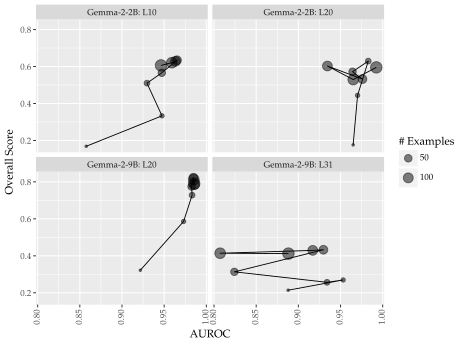

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: paper//concept10_scaling_factor.pdf


In [48]:
id_vars_sdl = ["identifier", "model", "layer", "# Examples"]
grouped_df = df[id_vars_sdl + ["AUROC", "Overall Score"]].groupby(id_vars_sdl).mean().reset_index()
plot = (
    ggplot(grouped_df, aes(x="AUROC", y="Overall Score"))
    + facet_wrap('model + ": " + layer')
    + geom_path() # arrow=arrow(type="closed", length=0.05)
    + geom_point(aes(size="# Examples"), alpha=0.5)
    # + geom_text(aes(label="Steering Factor", size=0.2), alpha=0.5, nudge_y=0.04)
    + theme(axis_text_x=element_text(angle=90, hjust=0.5))
)
plot.show()
plot.save(f"{PLOT_FOLDER}/concept10_scaling_factor.pdf", width=6, height=4)